In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn 
import torch.functional as F 
from torch.utils.data import Dataset, DataLoader

/home/sai-admin/anaconda3/envs/diffusion-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
class Sinusoidal():
    def __init__(self, eval_length=36, n_features=1, train_test_ratio=0.95):
        self.eval_length = eval_length
        self.n_features = n_features 

        num_freqs = 100
        time_steps = 1000
        freqs = list(np.linspace(1, 20, num_freqs))
        time = np.linspace(0, 2*np.pi, time_steps)

        data = [np.sin(2 * np.pi * freq * time) for freq in freqs]
        data = np.array(data)
        intervals = [(0+i,eval_length+i) for i in range(0,time_steps-eval_length)]
        dataset = np.zeros((len(intervals)*num_freqs, eval_length))

        for i in range(num_freqs):
            orig_dataset = data[i] 
            for j in range(len(intervals)):
                min_ = intervals[j][0]
                max_ = intervals[j][1]
 
                idx = i*len(intervals)+j
                dataset[idx] = orig_dataset[min_:max_]
        self.dataset = torch.tensor(dataset).type(torch.FloatTensor)
        self.dataset = self.dataset.unsqueeze(-1)

        indices = torch.randperm(self.dataset.size(0))
        num_training_indices = int(self.dataset.size(0)*train_test_ratio)
        train_indices = indices[:num_training_indices]
        test_indices = indices[num_training_indices:]
        self.train_dataset = self.dataset[train_indices]
        self.test_dataset = self.dataset[test_indices]

horizon = 48
input_features = 1
sinusoidal_data = Sinusoidal(eval_length=horizon, n_features=input_features)

class GetDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset 
    
    def __getitem__(self, org_index):
        return self.dataset[org_index]

    def __len__(self):
        return self.dataset.shape[0]
    
train_dataset = GetDataset(sinusoidal_data.train_dataset)
test_dataset = GetDataset(sinusoidal_data.test_dataset)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

In [17]:
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=16):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features, # 1
      hidden_size=self.hidden_dim, # 32
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim, 
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x, (_, _) = self.rnn1(x) # the shape of x is 1x140x32
    x, (hidden_n, _) = self.rnn2(x)
    flat_dim = self.rnn2.num_layers*2*self.embedding_dim if self.rnn2.bidirectional else self.rnn2.num_layers*self.embedding_dim
    return hidden_n.permute(1,0,2).view(-1,flat_dim).unsqueeze(1)
  
class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(1, self.seq_len, 1)
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((-1, self.hidden_dim))
    x = self.output_layer(x)
    return x.reshape(-1, self.seq_len, self.n_features)
  
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x
  
model = RecurrentAutoencoder(seq_len=horizon, n_features=input_features, embedding_dim=16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
def train_model(model, train_dataloader, val_dataloader, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataloader:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataloader:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

model, history = train_model(
  model, 
  train_dataloader, 
  val_dataloader, 
  n_epochs=4000
)

Epoch 1: train loss 1899.4621382825276 val loss 1831.808271484375
Epoch 2: train loss 1819.8135899674605 val loss 1772.4723714192708
Epoch 3: train loss 1739.3255723901989 val loss 1699.218133138021
Epoch 4: train loss 1696.9342186157571 val loss 1664.6967024739583
Epoch 5: train loss 1665.461044678425 val loss 1650.808681640625
Epoch 6: train loss 1648.59747860489 val loss 1626.3867513020834
Epoch 7: train loss 1626.7921858899495 val loss 1604.2445450846353
Epoch 8: train loss 1597.5384878889674 val loss 1567.9248828125
Epoch 9: train loss 1559.9899344005883 val loss 1516.2609391276042
Epoch 10: train loss 1519.5506388490237 val loss 2122.807023111979
Epoch 11: train loss 1756.191963066306 val loss 1506.4136442057293
Epoch 12: train loss 1483.2545166015625 val loss 1435.7967350260417
Epoch 13: train loss 1418.1508143099902 val loss 1382.9042626953126
Epoch 14: train loss 1372.4231072713158 val loss 1342.752322591146
Epoch 15: train loss 1347.1033499797297 val loss 1299.2085017903646
E

KeyboardInterrupt: 

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

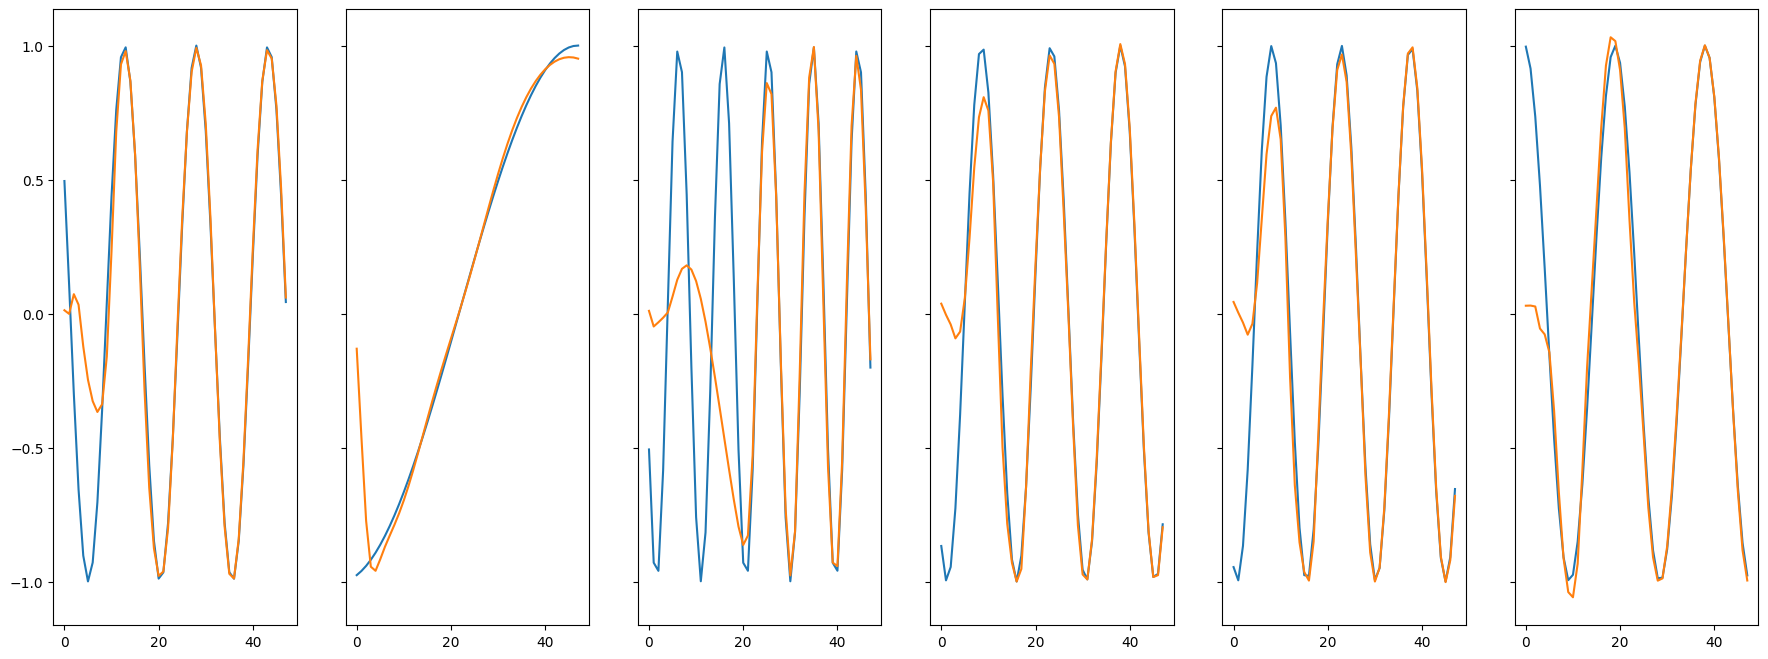

In [19]:
num_plots = 6

fig, axs = plt.subplots(
  nrows=1,
  ncols=num_plots,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

model = model.eval()
for data in val_dataloader:
  data = data.to(device)
  predictions = model(data)
  for i in range(num_plots):
    pred = predictions[i].squeeze(-1).cpu().detach().numpy()
    true = data[i].squeeze(-1).cpu().numpy()
    axs[i].plot(true, label='true')
    axs[i].plot(pred, label='reconstructed')
  break

axs.legend()

fig.tight_layout()